Epoch [1/7], Step [100/600], Loss: 0.4754
Epoch [1/7], Step [200/600], Loss: 0.4151
Epoch [1/7], Step [300/600], Loss: 0.3072
Epoch [1/7], Step [400/600], Loss: 0.4399
Epoch [1/7], Step [500/600], Loss: 0.4703
Epoch [1/7], Step [600/600], Loss: 0.2840
Epoch [2/7], Step [100/600], Loss: 0.2255
Epoch [2/7], Step [200/600], Loss: 0.3307
Epoch [2/7], Step [300/600], Loss: 0.2826
Epoch [2/7], Step [400/600], Loss: 0.2025
Epoch [2/7], Step [500/600], Loss: 0.1530
Epoch [2/7], Step [600/600], Loss: 0.2687
Epoch [3/7], Step [100/600], Loss: 0.2559
Epoch [3/7], Step [200/600], Loss: 0.4016
Epoch [3/7], Step [300/600], Loss: 0.2907
Epoch [3/7], Step [400/600], Loss: 0.2772
Epoch [3/7], Step [500/600], Loss: 0.1774
Epoch [3/7], Step [600/600], Loss: 0.1744
Epoch [4/7], Step [100/600], Loss: 0.2264
Epoch [4/7], Step [200/600], Loss: 0.1914
Epoch [4/7], Step [300/600], Loss: 0.1640
Epoch [4/7], Step [400/600], Loss: 0.1756
Epoch [4/7], Step [500/600], Loss: 0.2331
Epoch [4/7], Step [600/600], Loss:

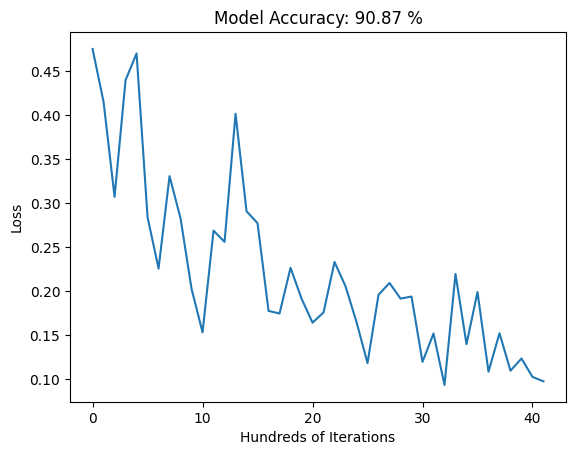

Predicted Label for Image below is Ankle Boot


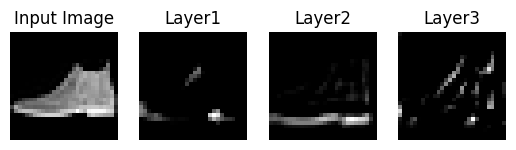

Predicted Label for Image below is Pullover


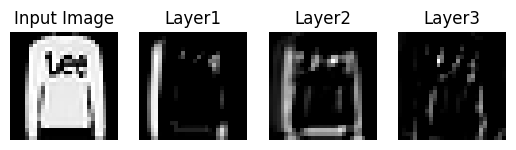

Predicted Label for Image below is Trouser


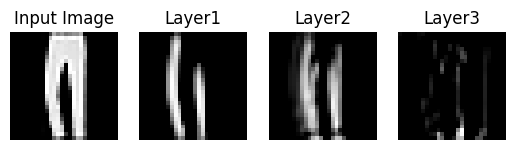

Predicted Label for Image below is Trouser


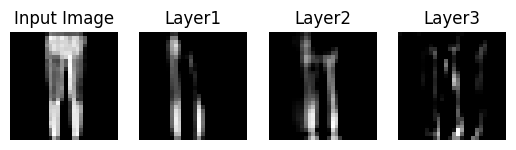

Predicted Label for Image below is Shirt


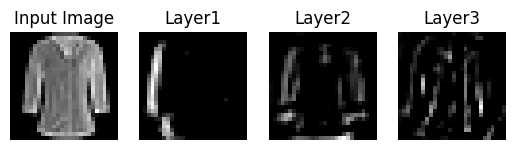

Predicted Label for Image below is Trouser


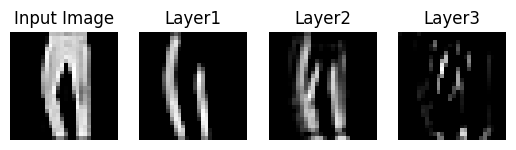

Predicted Label for Image below is Coat


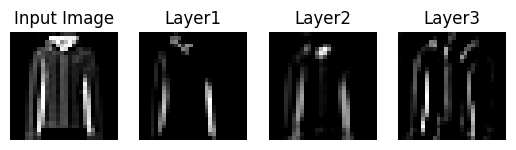

Predicted Label for Image below is Shirt


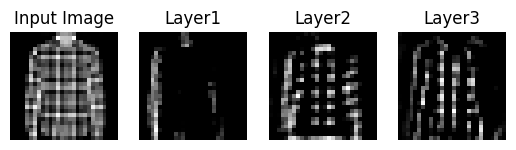

Predicted Label for Image below is Sandal


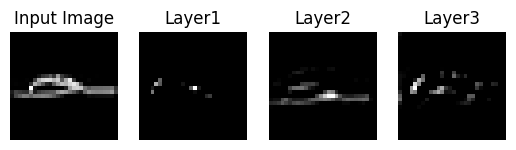

Predicted Label for Image below is Sneaker


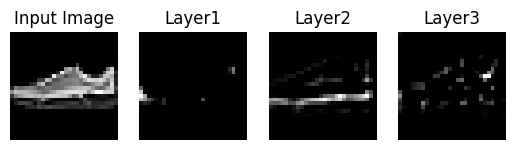

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
# config device
device = torch.device('cpu')

# hyper-parameters
num_epochs = 7
num_classes = 10
batch_size = 100
learning_rate = 0.001
alpha = 1  # 0 iff linear, 1 iff ReLU

# FashionMNIST dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='../../data/',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)
test_dataset = torchvision.datasets.FashionMNIST(
    root='../../data/',
    train=False,
    transform=transforms.ToTensor()
)

# Data load
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# # function to show an image
# def imshow(img):
#     img = img / 2 + 0.5
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# # get some random training images from the dataset
# dataiter = iter(train_loader)
# images, labels = dataiter.__next__()
# # show images
# imshow(torchvision.utils.make_grid(images))

# CNN(three layer)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2), #inChannels, outChannels, kernel_size, stride, padding
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.fc = nn.Linear(25088, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)

# Loss and optimize
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#Storing loss
losses = []

# Train
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            losses.append(loss.item())
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

from torchvision import utils
# Test the model
model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Model Accuracy on the 10000 test images: {} %'.format(100 * correct / total))

# Plot loss
plt.plot(losses)
plt.title('Model Accuracy: {} %'.format(100 * correct / total))
plt.xlabel('Hundreds of Iterations')
plt.ylabel('Loss')
# Save the plot as a PNG file
plt.savefig('training_loss_plot_ReLU.png')
plt.show()


names= ['T-shirt/top', 'Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
# Plot feature map (to adjust based on number of layer)
with torch.no_grad():
    for i in range(10):  # Iterate through 10 images
        images, labels = iter(test_loader).__next__()
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        print('Predicted Label for Image below is', names[predicted[i]])

        image_list = [
            images[i][0].cpu().numpy(),
            model.layer1(images)[i][0].cpu().numpy(),
            model.layer2(model.layer1(images))[i][0].cpu().numpy(),
            model.layer3(model.layer2(model.layer1(images)))[i][0].cpu().numpy()
        ]

        # Display feature maps
        for j, feature_map in enumerate(image_list):
            plt.subplot(1, len(image_list), j + 1)
            plt.imshow(feature_map, cmap='gray')  # Display grayscale image
            if(j==0):
                plt.title('Input Image')
            if(j>0): 
                plt.title(f'Layer{j}')
            plt.axis('off')
        plt.savefig('Feature_map_ReLU_{}.png'.format(i))
        plt.show()


In [2]:
#Save the model
torch.save(model.state_dict(), 'ReLU.ckpt')